In [1]:
#We can go into our root file and see what Trees are availiable
%matplotlib inline
import sys, os
if __package__ is None:
    import sys, os
    sys.path.append(os.path.realpath("/data/shared/Software/"))
    sys.path.append(os.path.realpath("../../"))
import matplotlib.pyplot as plt
from matplotlib import mlab
import numpy as np
import pandas as pd
import ntpath
import glob
import deepconfig
from keras.datasets import mnist
from keras import objectives
from keras import backend as K

from keras.utils.visualize_util import plot
from keras.utils import np_utils
from IPython.display import Image, display

from CMS_SURF_2016.utils.metrics import plot_history, print_accuracy_m
from CMS_SURF_2016.utils.callbacks import OverfitStopping, SmartCheckpoint
from CMS_SURF_2016.utils.keras_trial import *

from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Reshape, Activation, Dropout, Convolution2D, merge, Input, Lambda
from keras.callbacks import EarlyStopping


dc = deepconfig.deepconfig(gpu='gpu0', backend='theano')

batch_size = 16
original_dim = 784
latent_dim = 2
intermediate_dim = 128
nb_epoch = 40

x = Input(batch_shape=(batch_size, original_dim))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_std = Dense(latent_dim)(h)


Using Theano backend.
Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN not available)

Couldn't import dot_parser, loading of dot files will not be possible.
using gpu0
using theano


In [2]:
earlyStopping = EarlyStopping(verbose=1, patience=10)
overfitStopping = OverfitStopping(verbose=1, patience=20)
# this is the size of our encoded representations
# this is our input placeholder
def genModel(latent_dim):
    
    coders = []
    input_img = Input(shape=(784,))

    # "encoded" is the encoded representation of the input
    encoded = Dense(128, activation='relu')(input_img)
    encoded = Dense(64, activation='relu')(encoded)
    encoded = Dense(latent_dim, activation='relu')(encoded)

    # "decoded" is the lossy reconstruction of the input
    decoded = Dense(64, activation='relu')(encoded)
    decoded = Dense(128, activation='relu')(decoded)
    decoded = Dense(784, activation='sigmoid')(decoded)

    # this model maps an input to its reconstruction
    autoencoder = Model(input=input_img, output=decoded)

    # this model maps an input to its encoded representation
    encoder = Model(input=input_img, output=encoded)

    # create a placeholder for an encoded (32-dimensional) input
    encoded_input = Input(shape=(latent_dim,))

    #encoder.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])

    # retrieve the last layer of the autoencoder model
    decoder_layer1 = autoencoder.layers[-3]
    decoder_layer2 = autoencoder.layers[-2]
    decoder_layer3 = autoencoder.layers[-1]

    # create the decoder model
    decoder = Model(input=encoded_input, output=decoder_layer3(decoder_layer2(decoder_layer1(encoded_input))))

    # Now let's train our autoencoder to reconstruct MNIST digits.
    # First, we'll configure our model to use a per-pixel binary crossentropy loss, and the Adadelta optimizer:

    autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy',metrics=['accuracy'])
    coders.append(encoder)
    coders.append(autoencoder)
    
    return coders
    #return encoder

In [3]:
(x_train,y_train), (x_test,y_test) = mnist.load_data()
noNine = y_train != 9

x_train = x_train[noNine]
y_train = y_train[noNine]

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [ ]:
autoencoders = []
trainingTime = []
latent_dim = [2,4,8,16,32]
for i in range(len(latent_dim)):
    model = genModel(latent_dim[i])[1]
    fitTime = time.time()
    model.fit(x_train, x_train,
            shuffle=True,
            nb_epoch=nb_epoch,
            batch_size=batch_size,
            callbacks=[earlyStopping, overfitStopping],
            validation_data=(x_test, x_test))
    fitTime = time.time() - fitTime
    trainingTime.append(fitTime)
    autoencoders.append(model)

Train on 54051 samples, validate on 10000 samples
Epoch 1/40
54051/54051 [==============================] - 9s - loss: 0.2656 - acc: 0.0134 - val_loss: 0.2376 - val_acc: 0.0149
Epoch 2/40
54051/54051 [==============================] - 9s - loss: 0.2311 - acc: 0.0123 - val_loss: 0.2253 - val_acc: 0.0074
Epoch 3/40
54051/54051 [==============================] - 9s - loss: 0.2210 - acc: 0.0123 - val_loss: 0.2156 - val_acc: 0.0125
Epoch 4/40
54051/54051 [==============================] - 9s - loss: 0.2141 - acc: 0.0135 - val_loss: 0.2104 - val_acc: 0.0108
Epoch 5/40
54051/54051 [==============================] - 9s - loss: 0.2092 - acc: 0.0113 - val_loss: 0.2065 - val_acc: 0.0131
Epoch 6/40
54051/54051 [==============================] - 9s - loss: 0.2050 - acc: 0.0111 - val_loss: 0.2034 - val_acc: 0.0076
Epoch 7/40
54051/54051 [==============================] - 9s - loss: 0.2015 - acc: 0.0107 - val_loss: 0.1998 - val_acc: 0.0118
Epoch 8/40
54051/54051 [==============================] - 9s 

In [6]:
# Get the validation accuracy and the number of parameters and training time for each autoencoder 
acc = []
numberParam = []
for i in range (len(autoencoders)):
    acc.append(autoencoders[i].evaluate(x_test, x_test, batch_size=32)[1])
    numberParam.append(autoencoders[i].count_params())
    print 'Autoencoder #',i+1
    print 'Val_Acc: ' ,acc[i]
    print 'Number of parametrs: ',numberParam[i]
    print 'Fitting time: ',trainingTime[i]
    print ' '


10000/10000 [==============================] - 0s     
Autoencoder # 1
Val_Acc:  0.0131
Number of parametrs:  218514
Fitting time:  384.557366133
 
10000/10000 [==============================] - 0s     
Autoencoder # 2
Val_Acc:  0.0164
Number of parametrs:  218772
Fitting time:  382.396655083
 
10000/10000 [==============================] - 0s     
Autoencoder # 3
Val_Acc:  0.0115
Number of parametrs:  219288
Fitting time:  374.716952085
 
10000/10000 [==============================] - 0s     
Autoencoder # 4
Val_Acc:  0.0141
Number of parametrs:  220320
Fitting time:  416.435791016
 
10000/10000 [==============================] - 0s     
Autoencoder # 5
Val_Acc:  0.0131
Number of parametrs:  222384
Fitting time:  416.133651018
 


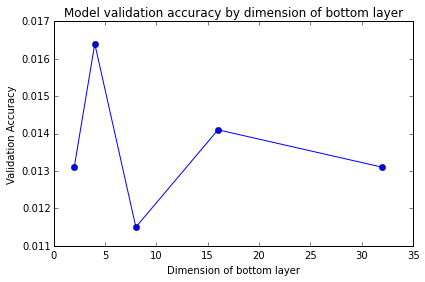

In [7]:
# Get the plot of validation accuracy by dimension of bottom layer
plt.xlabel('Dimension of bottom layer')
plt.ylabel('Validation Accuracy')
plt.title('Model validation accuracy by dimension of bottom layer')

plt.plot (latent_dim, acc, 'o-')
plt.tight_layout()
plt.show()

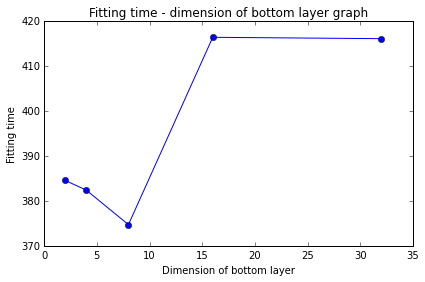

In [9]:
# Get the plot of model fitting time by dimension of bottom layer
plt.xlabel('Dimension of bottom layer')
plt.ylabel('Fitting time')
plt.title('Fitting time - dimension of bottom layer graph')

plt.plot (latent_dim, trainingTime, 'o-')
plt.tight_layout()
plt.show()

/usr/lib/python2.7/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


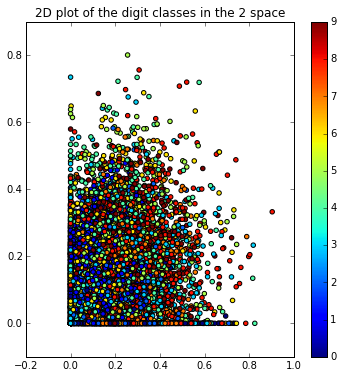

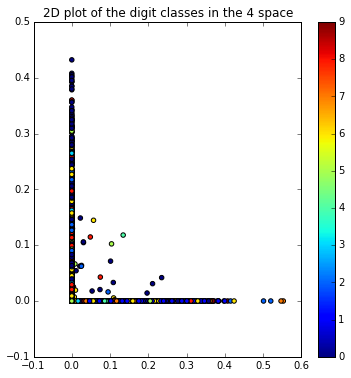

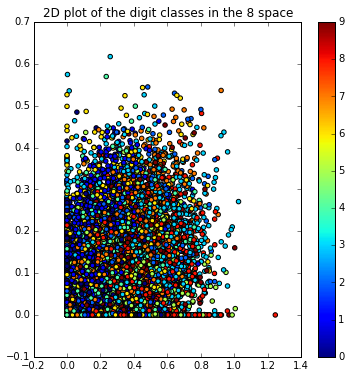

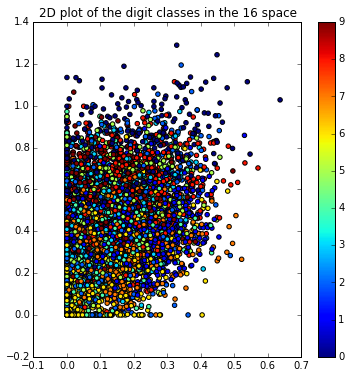

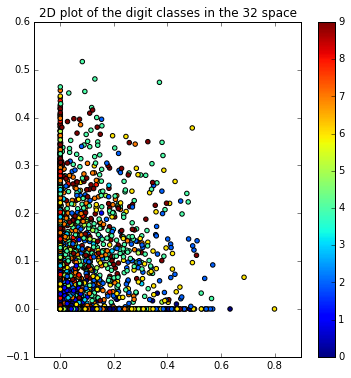

In [10]:
# display a 2D plot of the digit classes in the latent space
# build a model to project inputs on the latent space
for i in range(len(latent_dim)):
    encoder = genModel(latent_dim[i])[0]
    x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
    plt.figure(figsize=(6, 6))
    plt.title('2D plot of the digit classes in the %r space' % latent_dim[i])
    plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
    plt.colorbar()
    plt.show()

